# 2.0 - Feature Engineering - Team 34
Feature analysis and engineering exploration

## Setup

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fase2.config import config
from fase2.core.data_processor import DataProcessor

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


## 1. Load and Clean Data

In [13]:
# Use DataProcessor to clean data
processor = DataProcessor()

df_clean = (
    processor.load_raw_data()
    .translate_columns()
    .clean_whitespace()
    .convert_to_numeric()
    .validate_target()
    .handle_missing_values()
    .validate_categorical_ranges()
    .remove_duplicates()
    .get_data()
)

print(f"\n✓ Cleaned data shape: {df_clean.shape}")

2025-10-27 23:39:22.393 | DEBUG    | fase2.core.data_processor:__init__:39 - DataProcessor initialized
2025-10-27 23:39:22.395 | INFO     | fase2.core.data_processor:load_raw_data:59 - Loading data from: /Users/alejandrodiazvillagomez/Desktop/Proyecto/Fase2/data/raw/german_credit_modified.csv
2025-10-27 23:39:22.403 | SUCCESS  | fase2.core.data_processor:load_raw_data:62 - ✓ Data loaded: 1020 rows × 22 columns
2025-10-27 23:39:22.403 | INFO     | fase2.core.data_processor:translate_columns:79 - Translating column names from German to English...
2025-10-27 23:39:22.405 | SUCCESS  | fase2.core.data_processor:translate_columns:88 - ✓ Translated 21 column names
2025-10-27 23:39:22.406 | INFO     | fase2.core.data_processor:clean_whitespace:100 - Cleaning whitespace from all columns...
2025-10-27 23:39:22.407 | INFO     | fase2.core.data_processor:clean_whitespace:105 -   ✓ Dropped 'mixed_type_col'
2025-10-27 23:39:22.414 | SUCCESS  | fase2.core.data_processor:clean_whitespace:112 - ✓ White


✓ Cleaned data shape: (846, 21)


In [14]:
# Show cleaning summary
summary = processor.get_summary()
print("\nCleaning Summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")


Cleaning Summary:
  original_rows: 1020
  original_cols: 22
  final_rows: 846
  final_cols: 21
  rows_removed: 174
  rows_removed_pct: 17.06%
  retention_rate: 82.94%


## 2. Target Distribution (After Cleaning)

Target variable: credit_risk
credit_risk
1.0    590
0.0    256
Name: count, dtype: int64


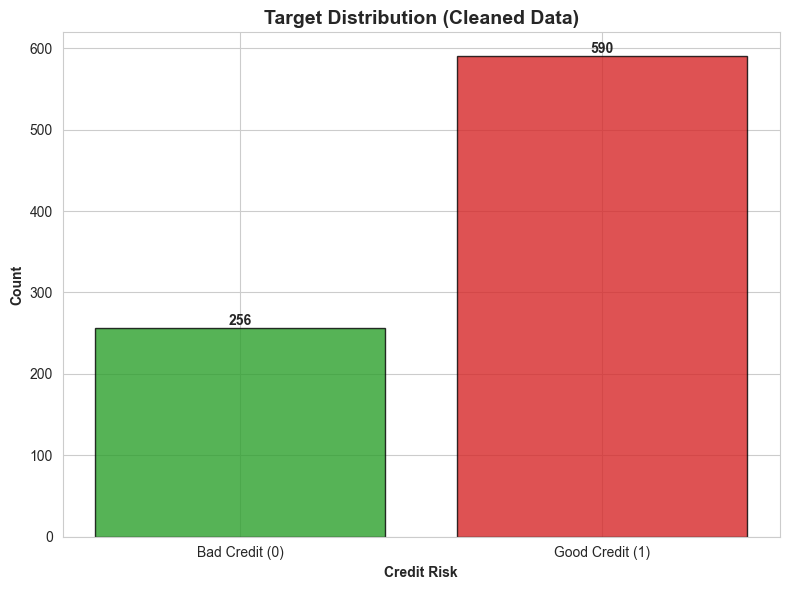


Class balance:
  Bad Credit (0): 256 (30.3%)
  Good Credit (1): 590 (69.7%)


In [15]:
target_col = config.data.target_col

print(f"Target variable: {target_col}")
print(df_clean[target_col].value_counts())

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
counts = df_clean[target_col].value_counts()
colors = ["#d62728", "#2ca02c"]
bars = ax.bar(counts.index, counts.values, color=colors, edgecolor="black", alpha=0.8)

ax.set_title("Target Distribution (Cleaned Data)", fontsize=14, fontweight="bold")
ax.set_xlabel("Credit Risk", fontweight="bold")
ax.set_ylabel("Count", fontweight="bold")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Bad Credit (0)", "Good Credit (1)"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# Calculate class balance
class_counts = df_clean[target_col].value_counts()
print(f"\nClass balance:")
print(f"  Bad Credit (0): {class_counts[0]} ({100*class_counts[0]/len(df_clean):.1f}%)")
print(
    f"  Good Credit (1): {class_counts[1]} ({100*class_counts[1]/len(df_clean):.1f}%)"
)

## 3. Feature Statistics

In [16]:
# Separate features by type
continuous_features = [
    f for f in config.data.continuous_features if f in df_clean.columns
]

print(f"Continuous features ({len(continuous_features)}):")
print(df_clean[continuous_features].describe())

Continuous features (6):
           duration         amount  installment_rate          age  \
count    846.000000     846.000000        846.000000   846.000000   
mean      95.670213    4321.022459          3.356974    45.908983   
std     2000.744306   30549.304467          6.850059   173.873279   
min        4.000000     250.000000          1.000000    19.000000   
25%       12.000000    1386.500000          2.000000    27.000000   
50%       18.000000    2325.500000          3.000000    33.000000   
75%       24.000000    3972.750000          4.000000    41.750000   
max    58140.000000  887992.000000        146.000000  4606.000000   

       residence_duration  existing_credits  
count          846.000000        846.000000  
mean             6.787234          4.522459  
std             51.374639         34.199330  
min              1.000000          1.000000  
25%              2.000000          1.000000  
50%              3.000000          1.000000  
75%              4.000000      

## 4. Outlier Analysis

In [17]:
# Detect outliers using IQR method
outlier_summary = {}

for col in continuous_features:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    outlier_summary[col] = {
        "outliers": outliers,
        "percentage": 100 * outliers / len(df_clean),
    }

outlier_df = pd.DataFrame(outlier_summary).T
outlier_df = outlier_df.sort_values("outliers", ascending=False)

print("\nOutlier Summary (IQR Method):")
print(outlier_df[outlier_df["outliers"] > 0])


Outlier Summary (IQR Method):
                    outliers  percentage
duration                63.0    7.446809
amount                  60.0    7.092199
age                     30.0    3.546099
existing_credits        17.0    2.009456
residence_duration       8.0    0.945626
installment_rate         3.0    0.354610


## 5. Feature Distributions (Cleaned Data)

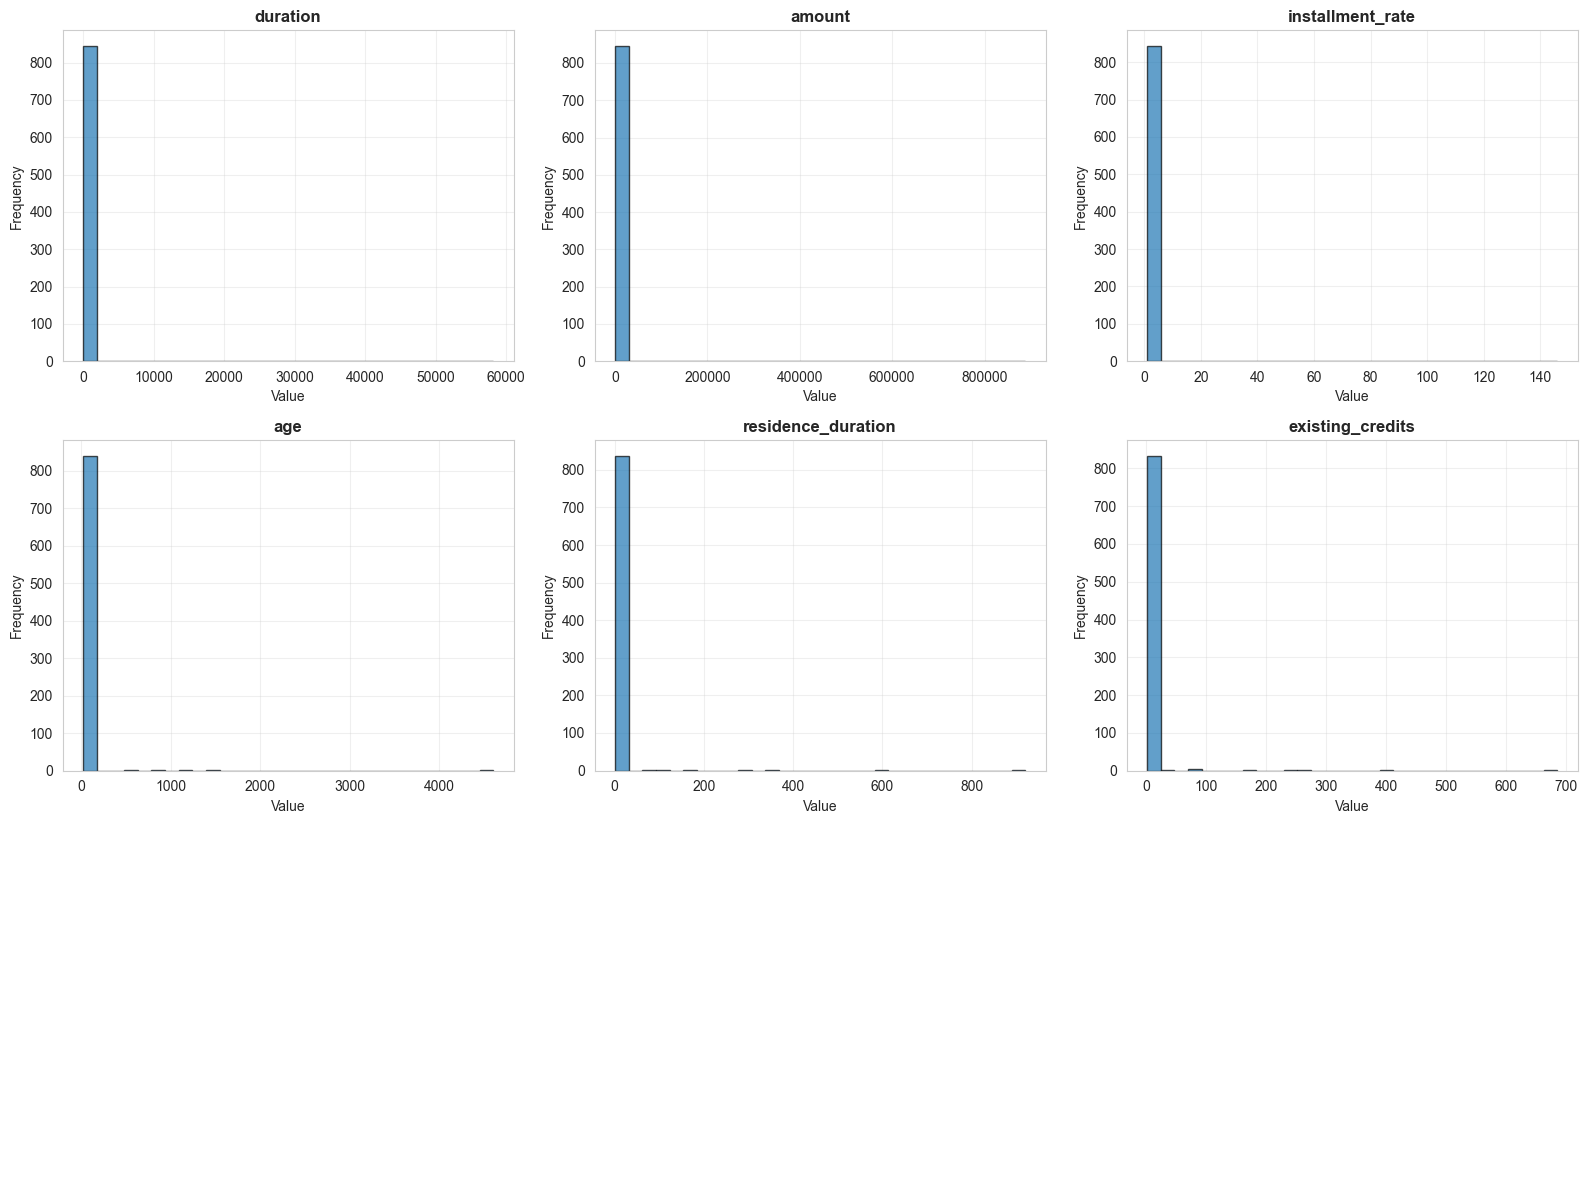

In [18]:
# Plot distributions
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(continuous_features[:9]):
    df_clean[col].hist(bins=30, ax=axes[idx], edgecolor="black", alpha=0.7)
    axes[idx].set_title(col, fontweight="bold")
    axes[idx].set_xlabel("Value")
    axes[idx].set_ylabel("Frequency")
    axes[idx].grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(continuous_features[:9]), 9):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

## 6. Correlation with Target


Top 10 features correlated with target:
checking_account           0.352730
credit_history             0.221240
savings_account            0.193440
employment_duration        0.149952
other_installment_plans    0.108988
personal_status            0.086648
other_debtors              0.048642
telephone                  0.039879
duration                   0.023481
age                        0.021525
dtype: float64


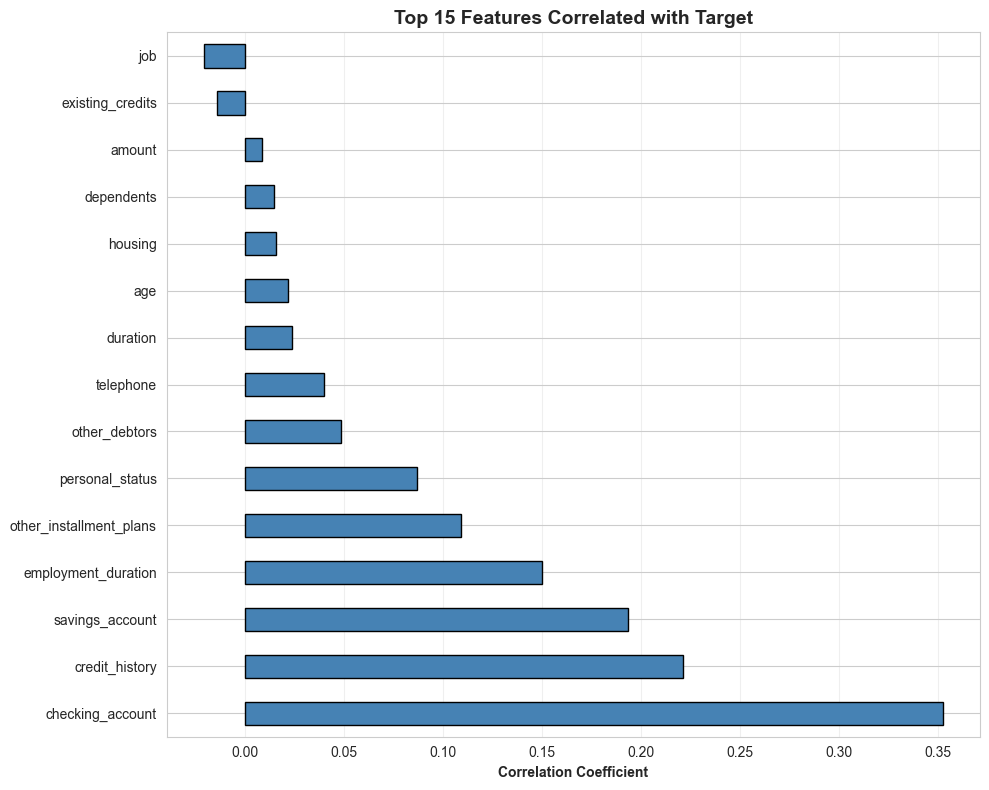

In [19]:
# Calculate correlation with target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

correlations = X.corrwith(y).sort_values(ascending=False)

print("\nTop 10 features correlated with target:")
print(correlations.head(10))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
correlations.head(15).plot(kind="barh", ax=ax, color="steelblue", edgecolor="black")
ax.set_title("Top 15 Features Correlated with Target", fontsize=14, fontweight="bold")
ax.set_xlabel("Correlation Coefficient", fontweight="bold")
ax.grid(alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

## 7. Feature Engineering Insights

In [20]:
# Check for highly correlated features (multicollinearity)
correlation_matrix = X.corr().abs()

# Find pairs with correlation > 0.8
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.8:
            high_corr_pairs.append(
                {
                    "Feature 1": correlation_matrix.columns[i],
                    "Feature 2": correlation_matrix.columns[j],
                    "Correlation": correlation_matrix.iloc[i, j],
                }
            )

if high_corr_pairs:
    print("\nHighly correlated feature pairs (>0.8):")
    for pair in high_corr_pairs:
        print(
            f"  {pair['Feature 1']} <-> {pair['Feature 2']}: {pair['Correlation']:.3f}"
        )
else:
    print("\n✓ No highly correlated feature pairs found (threshold: 0.8)")


✓ No highly correlated feature pairs found (threshold: 0.8)


## 8. Feature Scaling Comparison

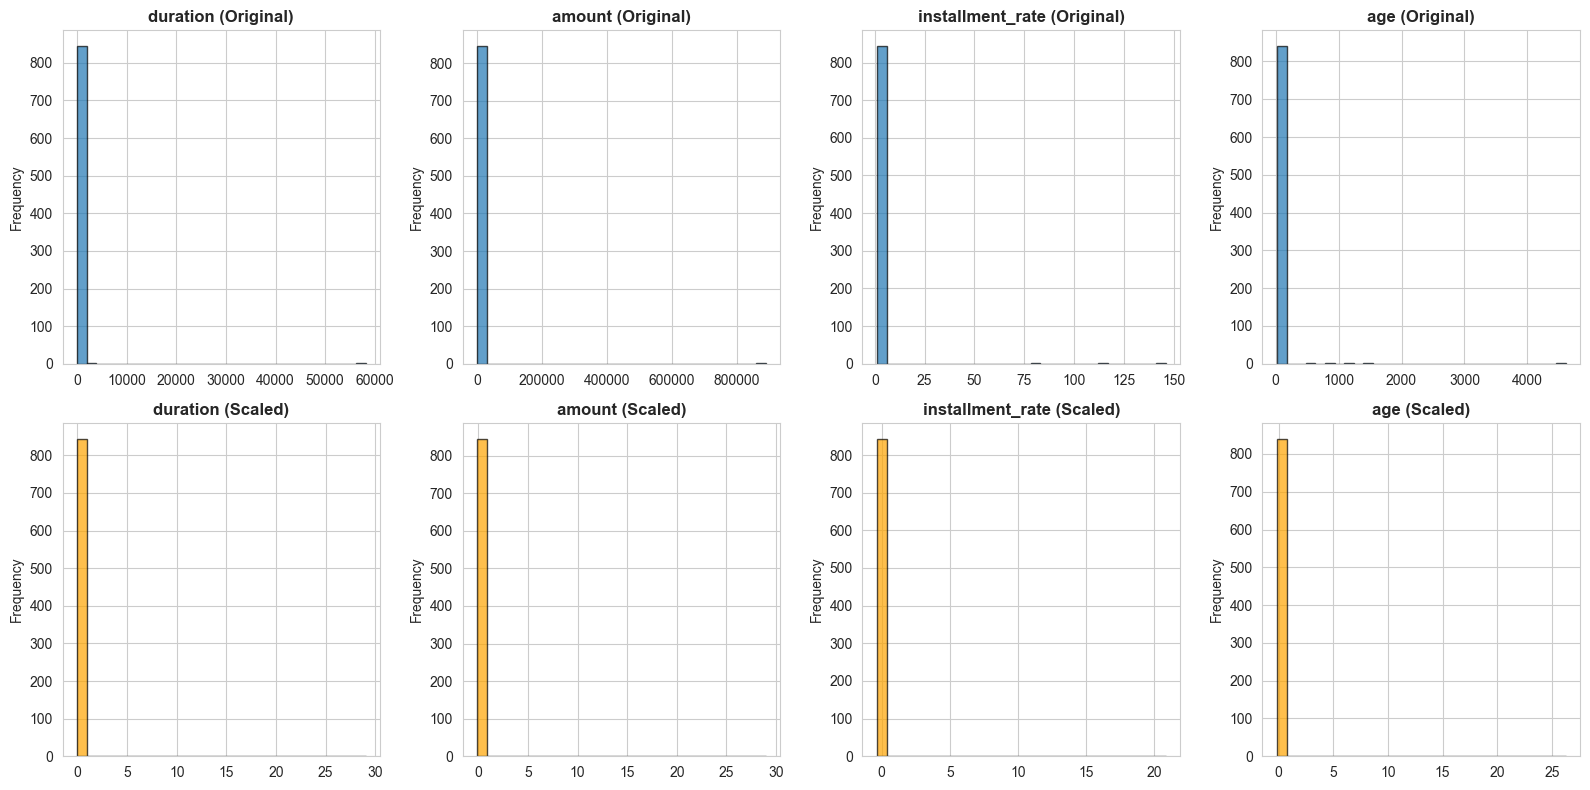

In [21]:
from sklearn.preprocessing import StandardScaler

# Show before/after scaling for sample features
sample_features = continuous_features[:4]

fig, axes = plt.subplots(2, len(sample_features), figsize=(16, 8))

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X[sample_features]), columns=sample_features
)

for idx, col in enumerate(sample_features):
    # Before scaling
    axes[0, idx].hist(X[col], bins=30, edgecolor="black", alpha=0.7)
    axes[0, idx].set_title(f"{col} (Original)", fontweight="bold")
    axes[0, idx].set_ylabel("Frequency")

    # After scaling
    axes[1, idx].hist(
        X_scaled[col], bins=30, edgecolor="black", alpha=0.7, color="orange"
    )
    axes[1, idx].set_title(f"{col} (Scaled)", fontweight="bold")
    axes[1, idx].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Summary

**Key Insights:**
- Data successfully cleaned using DataProcessor (OOP)
- Target variable is moderately imbalanced
- Several features show outliers
- Strong correlations identified between features and target
- Feature scaling will normalize distributions

**Next Steps:**
- Apply FeatureEngineer to handle outliers
- Create train-test split with stratification
- Scale features for model training
- Train ML models (Notebook 3)

In [22]:
print("\n✓ Feature Engineering Analysis Complete!")


✓ Feature Engineering Analysis Complete!
